# Search: Solving a Maze Using a Goal-based Agent

Student Name: Blake Gebhardt

I have used the following AI tools: ChatGPT 3.5 assisted with debugging and Python syntax.

I understand that my submission needs to be my own work: BWG

## Instructions

Total Points: Undergrads 100 / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a PDF file. 


## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root noteto the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [148]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`. 

In [149]:
import maze_helper as mh
import matplotlib

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

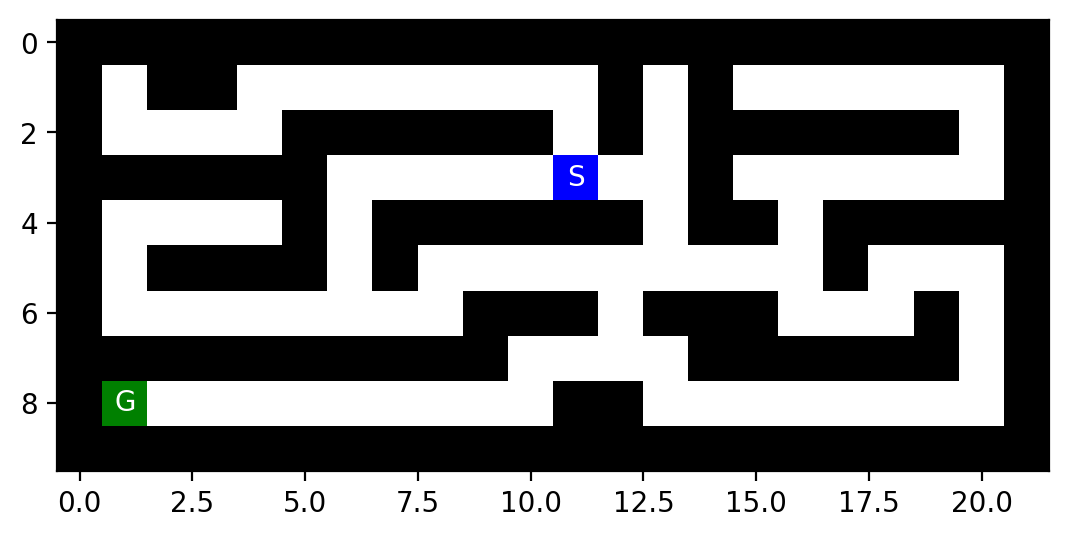

In [150]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

mh.show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [151]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [152]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    parse_maze(maze_str)
        Convert a maze as a string into a 2d numpy array
    
    show_maze(maze, fontsize=10)
        Display a (parsed) maze as an image.
    
    welcome()
        Welcome message.

FILE
    /Users/blakegebhardt/Desktop/CS7320-AI/Search/maze_helper.py




## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [153]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
    
        while not node.parent is None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        
        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

Since we need a method of keeping track of information later, I'll make a short class to help:

In [154]:
class info:
    def __init__(self, num_nodes_expanded=0, max_tree_depth=0, max_nodes_in_memory=0, max_frontier_size=0):
        self.num_nodes_expanded = num_nodes_expanded
        self.max_tree_depth = max_tree_depth
        self.max_nodes_in_memory = max_nodes_in_memory
        self.max_frontier_size = max_frontier_size

    def __repr__(self):
        return (
            f"Info(num_nodes_expanded={self.num_nodes_expanded}, "
            f"max_tree_depth={self.max_tree_depth}, "
            f"max_nodes_in_memory={self.max_nodes_in_memory}, "
            f"max_frontier_size={self.max_frontier_size})"
        )


# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the 
    - [small maze](small_maze.txt), 
    - [medium maze](medium_maze.txt), 
    - [large maze](large_maze.txt), 
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision. 
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formated professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
4. Document your code. Add a short discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate. 

*Note:* You can switch the next block from code to Markdown and use formatting.

## Task 1

The initial state represents the starting point in the maze from which the search begins.
This can be denoted as a specific cell or position in the maze, in this case an (x, y) coordinate.

In a maze, actions are moving in one of the possible directions: up, down, left, or right.

The maze solver explores possible actions (A(S)) available in the current state. For each action considered, the transitional model  calculates the resulting state (S') by applying the action to the current state: S' = Result(S, A).

The solver checks if the resulting state (S') is valid within the maze and not blocked by walls or obstacles.

The goal state is obviously the goal the solver is trying to reach. It is also represented as an (x, y) coordinate.

The path cost is a numerical value associated with the actions taken to reach a particular state from the initial state.
It represents the cost or distance accumulated along the path.

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determine these values for a given maze.

The state space size represents the total number of possible states or configurations in the maze. In a grid-based maze, each cell or node is a potential state.
To calculate n, count the total number of cells in the maze. If the maze is a grid of dimensions R x C (R rows and C columns), then n = R x C.

The depth of the optimal solution is the minimum number of steps or moves required to reach the goal state from the initial state.
You can find d by solving the maze optimally using any suitable algorithm and measuring the number of steps it took to reach the goal from the start.

The maximum depth of the tree represents the deepest level of exploration or recursion in a search tree during the maze-solving process.
m can be calculated by finding the longest path from the start node to any reachable node in the maze using any other traversal algorithm.

The maximum branching factor is the maximum number of child nodes that any node in the search tree can have.
You can determine b by examining the maze's structure. In our grid-based maze, b is equal to the number of adjacent cells that can be reached from a given cell. In our standard 4-connected grid (up, down, left, and right), b = 4.

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore. 
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DSF is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.

### This next section contains many helper functions for the agent as he solves the maze.

Functions to check if the agent can move in a certain direction:

In [155]:
def check_up(pos, maze):
    if mh.look(maze, (pos[0]-1,pos[1])) == 'X':
        return False
    else:
        return True

def check_down(pos, maze):
    if mh.look(maze, (pos[0]+1, pos[1])) == 'X':
        return False
    else:
        return True

def check_left(pos, maze):
    if mh.look(maze, (pos[0], pos[1]-1)) == 'X':
        return False
    else:
        return True

def check_right(pos, maze):
    if mh.look(maze, (pos[0], pos[1]+1)) == 'X':
        return False
    else:
        return True

Function that gets a list of actions that the agent can take at a given position.

In [156]:
def get_actions(pos, maze):
    actions = []
    if check_up(pos, maze):
        actions.append("up")
    if check_down(pos, maze):
        actions.append("down")
    if check_left(pos, maze):
        actions.append("left")
    if check_right(pos, maze):
        actions.append("right")
    return(actions)

Function that returns the new position after taking the action.

In [157]:
def get_new_pos(pos, action):
    new_pos = list(pos)
    if action == "up":
        new_pos[0] -= 1
    elif action == "down":
        new_pos[0] += 1
    elif action == "left":
        new_pos[1] -= 1
    elif action == "right":
        new_pos[1] += 1
    return(tuple(new_pos))

Cycle checker. Returns True if the new position is already in the path from the root to the current node.

In [158]:
def detect_cycle(node, new_pos):
    while not node.parent is None:
        node = node.parent
        if node.pos == new_pos:
            return True
    return False

Functions to move the frontier, the agent, and visited,

In [159]:
def change_symbol(maze, pos, newSymbol):
    x, y = pos
    maze[x, y] = newSymbol

def add_visited(maze, pos):
  if mh.look(maze, pos) != 'X':
    change_symbol(maze, pos, '.')

def add_frontier(maze, pos):
  if mh.look(maze, pos) == ' ':
    change_symbol(maze, pos, 'F')

Function to run through and set the final path from start to goal.

In [160]:
def set_final_path(maze, final_path):
  startLocation = mh.find_pos(maze, what="S")
  goalLocation = mh.find_pos(maze, what="G")
  for node in final_path:
    if node.pos != startLocation and node.pos != goalLocation:
      change_symbol(maze, node.pos, 'P')

### Breadth First Search!

In [161]:
#  max_nodes_in_memory max_frontier_size
def bfs_search(maze, start, goal, debug=False):
  thisInfo = info()
  # Create a queue for the frontier
  frontier = []

  # Create a set for the explored nodes
  visited = set()
  
  # Create the root node (position, parent, action, cost)
  root = Node(start, None, None, 0)
  
  # Add the root node to the frontier
  frontier.append(root)

  # Loop until the frontier is empty
  while len(frontier) > 0:
    if debug:
      mh.show_maze(maze)

    # Get the first node from the frontier
    node = frontier.pop(0)

    # Check if the node is the goal
    # If it is, return the path from the root to the goal
    if node.pos == goal:
      return node.get_path_from_root(), thisInfo

    # Add the node to the explored set
    visited.add(node.pos)

    # Add the graphing for visited nodes
    if node.parent is not None:
      add_visited(maze, node.pos)
      thisInfo.num_nodes_expanded += 1

    # Get the possible actions from the current node
    actions = get_actions(node.pos, maze)
    
    # Loop through the actions
    for action in actions:
      # get the new position from the action
      new_pos = get_new_pos(node.pos, action)

      # Make sure the new position is not already visited
      if (new_pos in visited):
        continue

      # Create a new node
      new_node = Node(new_pos, node, action, node.cost + 1)
      thisInfo.max_tree_depth = max(
          thisInfo.max_tree_depth, len(new_node.get_path_from_root()))
      # For graph purposes, add the node to the frontier
      add_frontier(maze, new_node.pos)

      # Add the new node to the frontier
      frontier.append(new_node)
      thisInfo.max_frontier_size = max(thisInfo.max_frontier_size, len(frontier))

      thisInfo.max_nodes_in_memory = thisInfo.max_tree_depth + thisInfo.max_frontier_size


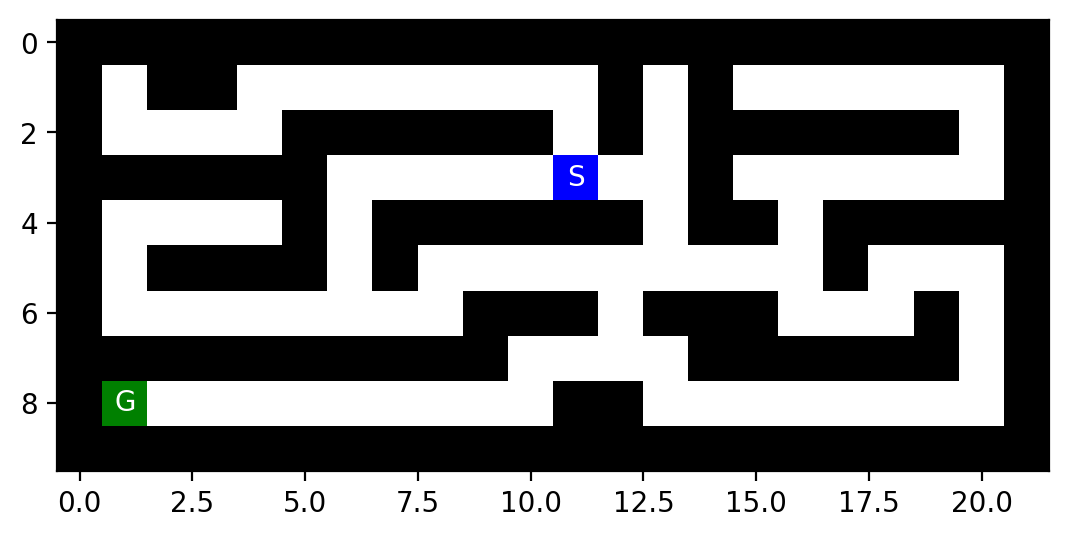

Info(num_nodes_expanded=92, max_tree_depth=20, max_nodes_in_memory=29, max_frontier_size=9)


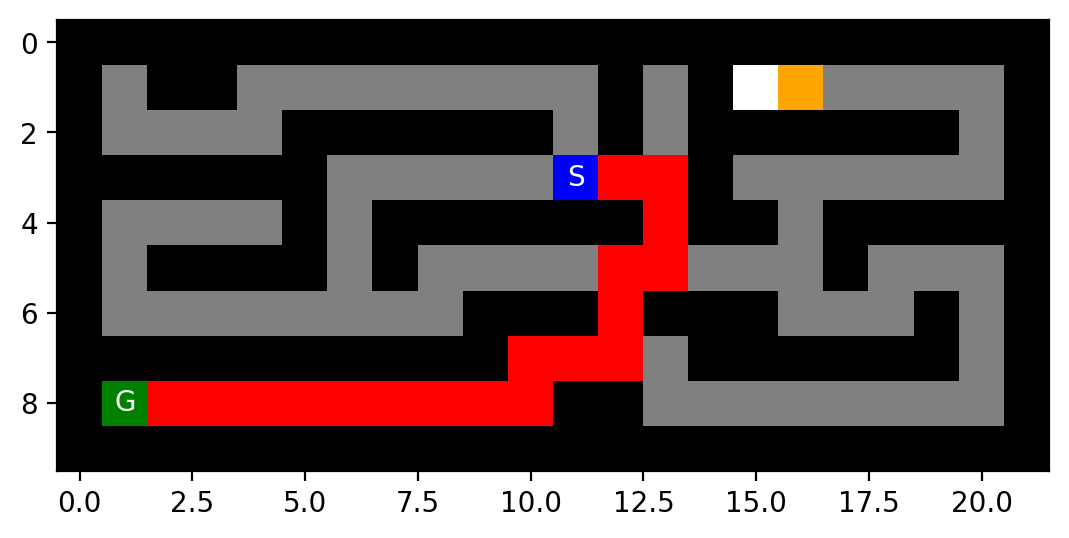

In [162]:
maze = mh.parse_maze(maze_str)

# The maze before
mh.show_maze(maze)

startLocation = mh.find_pos(maze, what="S")
goalLocation = mh.find_pos(maze, what="G")
final_bfs,bfsInfo = bfs_search(maze, startLocation, goalLocation)

print(bfsInfo)
set_final_path(maze, final_bfs)

# The maze after
mh.show_maze(maze)


### Depth First Search!

In [163]:
def dfs_search(maze, start, goal, debug=False):
    thisInfo = info()
    # create a stack for the frontier
    frontier = []

    # create the root node (position, parent, action, cost)
    root = Node(start, None, None, 0)

    # add the root node to the frontier
    frontier.append(root)

    # loop until the frontier is empty
    while len(frontier) > 0:
        # Print each iteration of the maze
        if debug:
            show_maze(maze)
        # get the last node from the frontier
        node = frontier.pop()

        # check if the node is the goal
        # if it is, return the path from the root to the goal
        if node.pos == goal:
            return (node.get_path_from_root(), thisInfo)

        # add the node to the explored set
        if node.parent is not None:
            add_visited(maze, node.pos)
            thisInfo.num_nodes_expanded+=1


        # get the possible actions from the current node
        actions = get_actions(node.pos, maze)        

        # loop through the actions
        for action in actions:
            # get the new position from the action
            new_pos = get_new_pos(node.pos, action)

            # make sure the new position is not already visited
            if (detect_cycle(node, new_pos)):
                continue

            # create a new node
            new_node = Node(new_pos, node, action, node.cost + 1)
            thisInfo.max_tree_depth = max(thisInfo.max_tree_depth, len(new_node.get_path_from_root()))

            # For graph purposes, add the node to the frontier
            add_frontier(maze, new_node.pos)

            # add the new node to the frontier
            frontier.append(new_node)
            thisInfo.max_frontier_size = max(thisInfo.max_frontier_size, len(frontier))

            thisInfo.max_nodes_in_memory = thisInfo.max_tree_depth + thisInfo.max_frontier_size


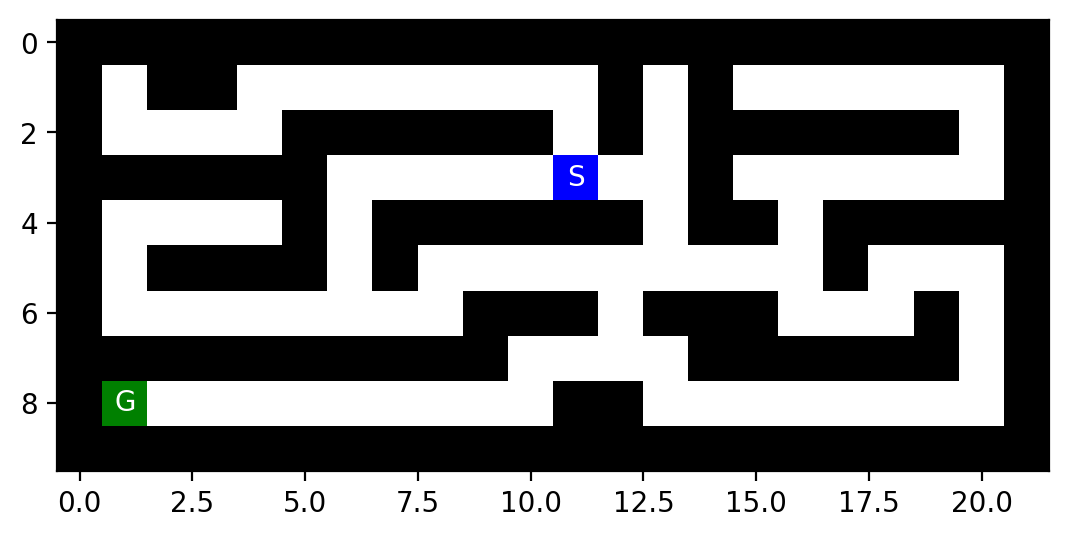

Info(num_nodes_expanded=36, max_tree_depth=38, max_nodes_in_memory=45, max_frontier_size=7)


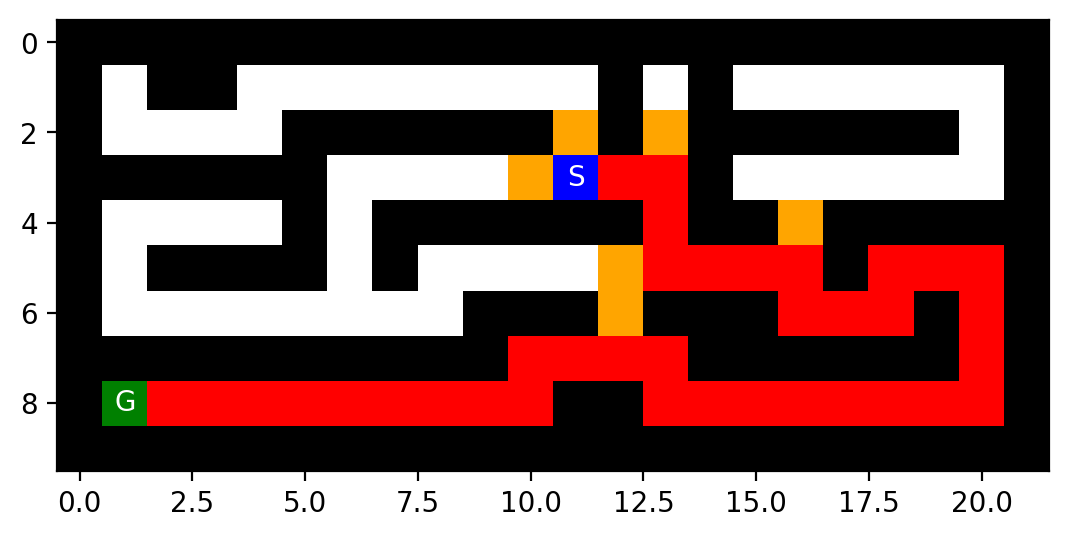

In [164]:
maze = mh.parse_maze(maze_str)

# The maze before
mh.show_maze(maze)

startLocation = mh.find_pos(maze, what = "S")
goalLocation = mh.find_pos(maze, what = "G")
final_dfs, dfsInfo = dfs_search(maze, startLocation, goalLocation)

print(dfsInfo)

set_final_path(maze, final_dfs)

# The maze after
mh.show_maze(maze)

How does BFS and DFS deal with loops (cycles)?

BFS systematically explores nodes at the current depth level before proceeding deeper into the graph. This approach guarantees that BFS won't get trapped in infinite loops, but it may revisit nodes at multiple levels, potentially making it less efficient for certain tasks.

On the other hand, DFS explores as deeply as possible along a branch before backtracking. While this approach can be efficient for some search tasks, it's susceptible to getting stuck in infinite loops if not used carefully. To prevent this, DFS often requires cycle detection mechanisms or constraints on exploration depth to ensure termination. Despite these differences, both BFS and DFS have their unique strengths and are valuable tools in various graph-based problem-solving scenarios.

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

My breadth first search is optimal. In a maze with equal weights of 0, the time complexity should be O(N) and the space complexity should be O(N).
The implementation uses O(N) space, where N is the number of nodes in the tree. This is because the algorithm, in the worst case, will store every node in the frontier. It also uses O(N) time. In the worst case, the algorithm will visit every node in the tree.

My depth first search implementation is not optimal, since an optimal DFS implementation should have a time complexity of O(N). My DFS implementation uses O(B^M), where B is the branching factor, and M is the maximum depth of the tree. In the worst case, the algorithm will be O(4^N), where N is the number of nodes in the tree.  The implementation uses O(N) space complexity, where N is the number of nodes in the tree. In the worse case, the algo will store every node in the frontier.

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides). 

Taxicab distance!

In [122]:
# Your code goes here

def get_manhattan_distance(pos1, pos2):
  return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

A* Search implementation!

In [123]:
def a_star_search(maze, start, goal, debug=False):
  thisInfo = info()
  # Create a queue for the frontier
  frontier = []

  # Create a set for the explored nodes
  visited = set()
  
  # Create the root node (position, parent, action, cost)
  root = Node(start, None, None, 0)
  
  # Add the root node to the frontier
  frontier.append(root)

  # Loop until the frontier is empty
  while len(frontier) > 0:
    if debug:
      show_maze(maze)

    # Get the first node from the frontier
    node = frontier.pop(0)

    # Check if the node is the goal
    # If it is, return the path from the root to the goal
    if node.pos == goal:
      return node.get_path_from_root(), thisInfo

    # Add the node to the explored set
    visited.add(node.pos)

    # Add the graphing for visited nodes
    if node.parent is not None:
      add_visited(maze, node.pos)
      thisInfo.num_nodes_expanded += 1

    # Get the possible actions from the current node
    actions = get_actions(node.pos, maze)
    
    # Loop through the actions
    for action in actions:
      # get the new position from the action
      new_pos = get_new_pos(node.pos, action)

      # Make sure the new position is not already visited
      if (new_pos in visited):
        continue

      # Create a new node
      new_node = Node(new_pos, node, action, node.cost + 1)
      thisInfo.max_tree_depth = max(thisInfo.max_tree_depth, len(new_node.get_path_from_root()))

      # Add the heuristic to the cost
      new_node.cost += get_manhattan_distance(new_node.pos, goal)

      # For graph purposes, add the node to the frontier
      add_frontier(maze, new_node.pos)

      # Add the new node to the frontier
      frontier.append(new_node)
      thisInfo.max_frontier_size = max(thisInfo.max_frontier_size, len(frontier))

      thisInfo.max_nodes_in_memory = thisInfo.max_tree_depth + thisInfo.max_frontier_size
    # Sort the frontier by cost
    frontier.sort(key=lambda x: x.cost)

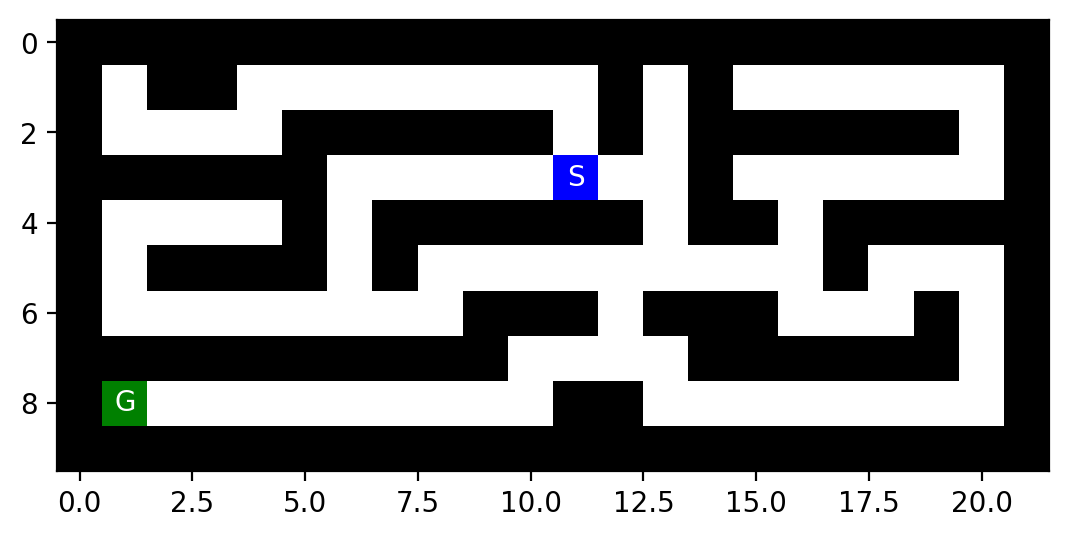

num_nodes_expanded = 74; max_tree_depth = 20; max_nodes_in_memory = 28; max_frontier_size = 8


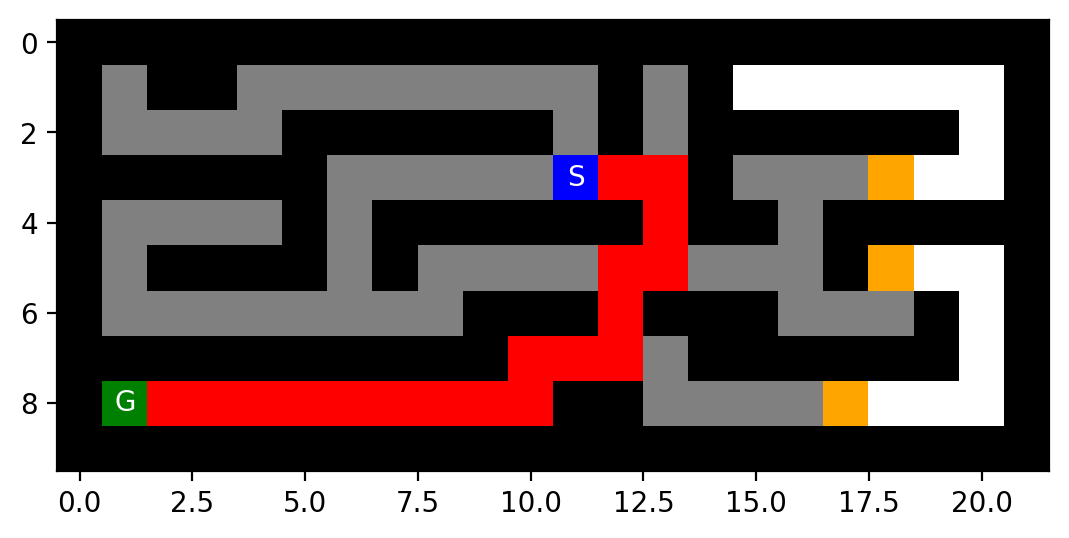

In [124]:
maze = mh.parse_maze(maze_str)

# The maze before
mh.show_maze(maze)

startLocation = mh.find_pos(maze, what="S")
goalLocation = mh.find_pos(maze, what="G")
final_aStar, aStarInfo = a_star_search(maze, startLocation, goalLocation)
 
print(aStarInfo)
set_final_path(maze, final_aStar)

# The maze after
mh.show_maze(maze)

Greedy BFS!

In [125]:
def greedy_Best_First_Search(maze, start, goal, debug=False):
  thisInfo = info()
  # Create a queue for the frontier
  frontier = []

  # Create a set for the explored nodes
  visited = set()
  
  # Create the root node (position, parent, action, cost)
  root = Node(start, None, None, 0)
  
  # Add the root node to the frontier
  frontier.append(root)

  # Loop until the frontier is empty
  while len(frontier) > 0:
    if debug:
      mh.show_maze(maze)

    # Get the first node from the frontier
    node = frontier.pop(0)

    # Check if the node is the goal
    # If it is, return the path from the root to the goal
    if node.pos == goal:
      return node.get_path_from_root(), thisInfo

    # Add the node to the explored set
    visited.add(node.pos)

    # Add the graphing for visited nodes
    if node.parent is not None:
      add_visited(maze, node.pos)
      thisInfo.num_nodes_expanded += 1

    # Get the possible actions from the current node
    actions = get_actions(node.pos, maze)
    
    # Loop through the actions
    for action in actions:
      # get the new position from the action
      new_pos = get_new_pos(node.pos, action)

      # Make sure the new position is not already visited
      if (new_pos in visited):
        continue

      # Create a new node
      new_node = Node(new_pos, node, action, get_manhattan_distance(new_pos, goal))
      thisInfo.max_tree_depth = max(thisInfo.max_tree_depth, len(new_node.get_path_from_root()))

      # For graph purposes, add the node to the frontier
      add_frontier(maze, new_node.pos)

      # Add the new node to the frontier
      frontier.append(new_node)
      thisInfo.max_frontier_size = max(thisInfo.max_frontier_size, len(frontier))

      thisInfo.max_nodes_in_memory = thisInfo.max_tree_depth + thisInfo.max_frontier_size
    # Sort the frontier by cost
    frontier.sort(key=lambda x: x.cost)

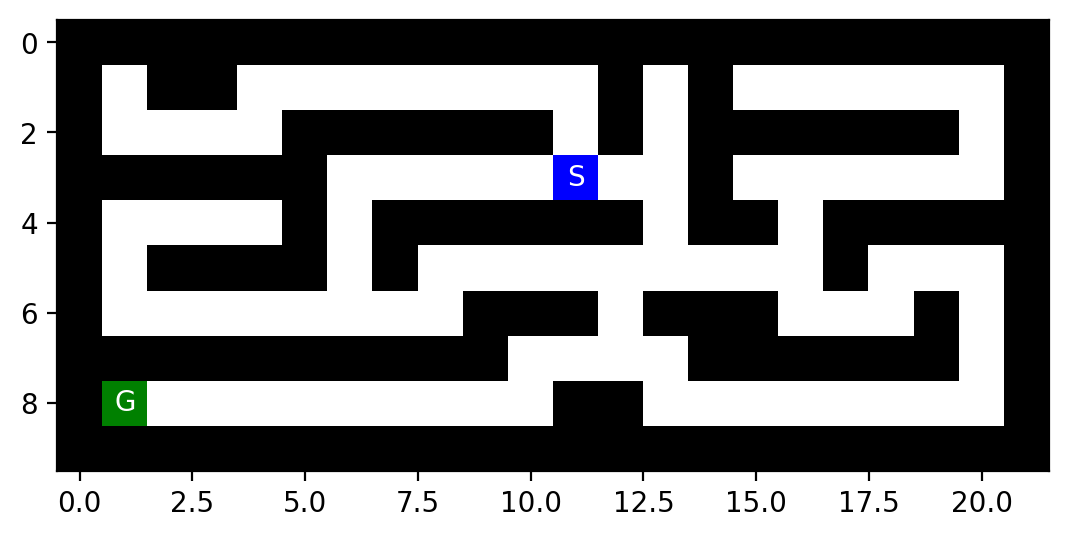

num_nodes_expanded = 38; max_tree_depth = 30; max_nodes_in_memory = 35; max_frontier_size = 5


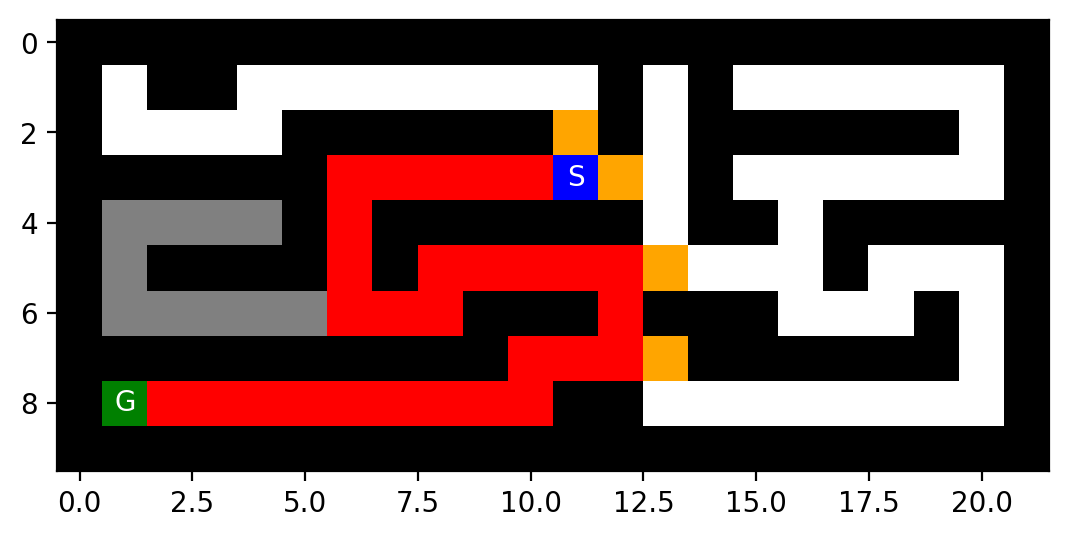

In [126]:
maze = mh.parse_maze(maze_str)

# The maze before
mh.show_maze(maze)

startLocation = mh.find_pos(maze, what="S")
goalLocation = mh.find_pos(maze, what="G")
final_gbfs, gbInfo = greedy_Best_First_Search(maze, startLocation, goalLocation)

print(gbInfo)
set_final_path(maze, final_gbfs)

# The maze after
mh.show_maze(maze)


Are your implementations complete and optimal? What is the time and space complexity?

My implementation of A* is likely suboptimal. The heuristic may drastically affect performance. Each node is just weighted as 1, so giving different weights may help. The time complexity is O(B*D), with B as branching factor and D is the optimal solution depth. In the worst case, the algorithm is O(4N), which is O(N). Space complexity is just the same as BFS, which is O(N).

As for Greedy Best First Search, this is an optimal implementation. The time complexity if O(B\*D), with the same justification as A* search. The space complexity is just the same as BFS, which is O(N).

## Task 4: Comparison and discussion [20 Points] 

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [145]:
# Creation of Tables
from tabulate import tabulate

files = [
    'small_maze.txt',
    'medium_maze.txt',
    'large_maze.txt',
    'empty_maze.txt',
    'empty_2_maze.txt',
    'loops_maze.txt',
    'wall_maze.txt'
]

# Define headers for the table
table_headers = ["algorithm", "path cost", "# of nodes expanded", "max tree depth", "max # of nodes in memory", "max frontier size"]

# Create an empty list to store the table rows
table_rows = []

# Run each algorithm on each maze
for file in files:
    maze_str = open(file, "r").read()
    maze = mh.parse_maze(maze_str)

    startLocation = mh.find_pos(maze, what="S")
    goalLocation = mh.find_pos(maze, what="G")
    
    # Run your search algorithms here and collect the results
    finaldfs, dfsinfo = dfs_search(maze, startLocation, goalLocation)
    finalbfs, bfsinfo = bfs_search(maze, startLocation, goalLocation)
    finalAStar, aStarInfo = a_star_search(maze, startLocation, goalLocation)
    finalgbfs, gbInfo = greedy_Best_First_Search(maze, startLocation, goalLocation)

    # Create a table for the current maze
    maze_table = []
    maze_table.append(["BFS", len(finalbfs), bfsinfo.num_nodes_expanded, bfsinfo.max_tree_depth, bfsinfo.max_nodes_in_memory, bfsinfo.max_frontier_size])
    maze_table.append(["DFS", len(finaldfs), dfsinfo.num_nodes_expanded, dfsinfo.max_tree_depth, dfsinfo.max_nodes_in_memory, dfsinfo.max_frontier_size])
    maze_table.append(["GBFS", len(finalgbfs), gbInfo.num_nodes_expanded, gbInfo.max_tree_depth, gbInfo.max_nodes_in_memory, gbInfo.max_frontier_size])
    maze_table.append(["A*", len(finalAStar), aStarInfo.num_nodes_expanded, aStarInfo.max_tree_depth, aStarInfo.max_nodes_in_memory, aStarInfo.max_frontier_size])
    
    # Tabulate the maze table as a string
    maze_table_str = tabulate(maze_table, headers=table_headers, tablefmt="github")

    # Print the maze title and table
    print(f"__{file.capitalize()}__\n")
    print(maze_table_str)
    print("\n")


__Small_maze.txt__

| algorithm   |   path cost |   # of nodes expanded |   max tree depth |   max # of nodes in memory |   max frontier size |
|-------------|-------------|-----------------------|------------------|----------------------------|---------------------|
| BFS         |          20 |                    92 |               20 |                         29 |                   9 |
| DFS         |          38 |                    36 |               38 |                         45 |                   7 |
| GBFS        |          30 |                    38 |               30 |                         35 |                   5 |
| A*          |          20 |                    74 |               20 |                         28 |                   8 |


__Medium_maze.txt__

| algorithm   |   path cost |   # of nodes expanded |   max tree depth |   max # of nodes in memory |   max frontier size |
|-------------|-------------|-----------------------|------------------|-----------------

Complete the following table for each maze.

__Small_maze.txt__

| algorithm   |   path cost |   # of nodes expanded |   max tree depth |   max # of nodes in memory |   max frontier size |
|-------------|-------------|-----------------------|------------------|----------------------------|---------------------|
| BFS         |          20 |                    92 |               20 |                         29 |                   9 |
| DFS         |          38 |                    36 |               38 |                         45 |                   7 |
| GBFS        |          30 |                    38 |               30 |                         35 |                   5 |
| A*          |          20 |                    74 |               20 |                         28 |                   8 |


__Medium_maze.txt__

| algorithm   |   path cost |   # of nodes expanded |   max tree depth |   max # of nodes in memory |   max frontier size |
|-------------|-------------|-----------------------|------------------|----------------------------|---------------------|
| BFS         |          69 |                   274 |               70 |                         79 |                   9 |
| DFS         |         131 |                   145 |              131 |                        140 |                   9 |
| GBFS        |          75 |                    80 |               75 |                         80 |                   5 |
| A*          |          69 |                   263 |               81 |                         88 |                   7 |


__Large_maze.txt__

| algorithm   |   path cost |   # of nodes expanded |   max tree depth |   max # of nodes in memory |   max frontier size |
|-------------|-------------|-----------------------|------------------|----------------------------|---------------------|
| BFS         |         211 |                   619 |              211 |                        219 |                   8 |
| DFS         |         211 |                   386 |              223 |                        262 |                  39 |
| GBFS        |         211 |                   465 |              211 |                        232 |                  21 |
| A*          |         211 |                   584 |              211 |                        220 |                   9 |


__Empty_maze.txt__

| algorithm   |   path cost |   # of nodes expanded |   max tree depth |   max # of nodes in memory |   max frontier size |
|-------------|-------------|-----------------------|------------------|----------------------------|---------------------|
| BFS         |          15 |                 13539 |               16 |                       9454 |                9438 |
| DFS         |          89 |                    87 |               89 |                        170 |                  81 |
| GBFS        |          15 |                    13 |               15 |                         45 |                  30 |
| A*          |          15 |                 10612 |               15 |                       9453 |                9438 |


__Empty_2_maze.txt__

| algorithm   |   path cost |   # of nodes expanded |   max tree depth |   max # of nodes in memory |   max frontier size |
|-------------|-------------|-----------------------|------------------|----------------------------|---------------------|
| BFS         |          15 |                 13539 |               16 |                       9454 |                9438 |
| DFS         |          71 |                    69 |               71 |                        146 |                  75 |
| GBFS        |          15 |                    13 |               15 |                         45 |                  30 |
| A*          |          15 |                 10612 |               15 |                       9453 |                9438 |


__Loops_maze.txt__

| algorithm   |   path cost |   # of nodes expanded |   max tree depth |   max # of nodes in memory |   max frontier size |
|-------------|-------------|-----------------------|------------------|----------------------------|---------------------|
| BFS         |          24 |                   204 |               24 |                         63 |                  39 |
| DFS         |          28 |                    29 |               28 |                         40 |                  12 |
| GBFS        |          24 |                   102 |               24 |                         45 |                  21 |
| A*          |          24 |                   197 |               24 |                         63 |                  39 |


__Wall_maze.txt__

| algorithm   |   path cost |   # of nodes expanded |   max tree depth |   max # of nodes in memory |   max frontier size |
|-------------|-------------|-----------------------|------------------|----------------------------|---------------------|
| BFS         |          15 |                  1303 |               16 |                        438 |                 422 |
| DFS         |          61 |                 12636 |               73 |                        133 |                  60 |
| GBFS        |          15 |                    13 |               15 |                         45 |                  30 |
| A*          |          15 |                   966 |               15 |                        437 |                 422 |




Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)). 

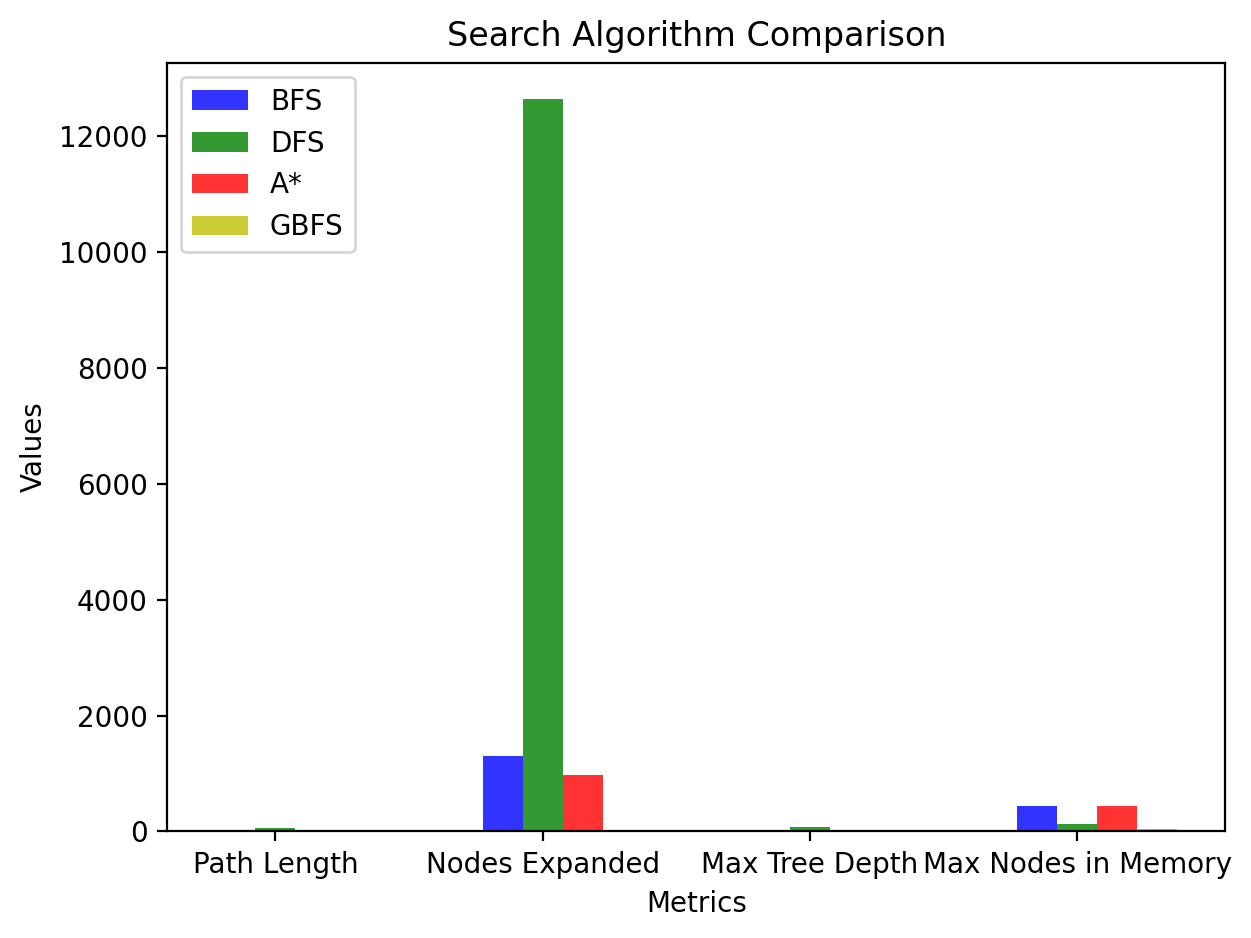

In [130]:
import matplotlib.pyplot as plt
import numpy as np

# Create data
n_groups = 4
bfs = (len(finalbfs), bfsinfo.num_nodes_expanded, bfsinfo.max_tree_depth, bfsinfo.max_nodes_in_memory)
dfs = (len(finaldfs), dfsinfo.num_nodes_expanded, dfsinfo.max_tree_depth, dfsinfo.max_nodes_in_memory)
aStar = (len(finalAStar), aStarInfo.num_nodes_expanded, aStarInfo.max_tree_depth, aStarInfo.max_nodes_in_memory)
gbfs = (len(finalgbfs), gbInfo.num_nodes_expanded, gbInfo.max_tree_depth, gbInfo.max_nodes_in_memory)

# Define the metrics
metrics = ['Path Length', 'Nodes Expanded', 'Max Tree Depth', 'Max Nodes in Memory']

# Create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8

rects1 = plt.bar(index, bfs, bar_width,
alpha=opacity,
color='b',
label='BFS')

rects2 = plt.bar(index + bar_width, dfs, bar_width,
alpha=opacity,
color='g',
label='DFS')

rects3 = plt.bar(index + bar_width*2, aStar, bar_width,
alpha=opacity,
color='r',
label='A*')

rects4 = plt.bar(index + bar_width*3, gbfs, bar_width,
alpha=opacity,
color='y',
label='GBFS')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Search Algorithm Comparison')
plt.xticks(index + bar_width, metrics)

# Add legend
plt.legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Discuss the most important lessons you have learned from implementing the different search strategies. 

In [131]:
# Add discussion

## Graduate student advanced task: IDS and Multiple goals [10 Points]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus Points].

Create a few mazes with multiple goals by adding one or two more goals to the medium size maze.
Solve the maze with your implementations for DFS, BFS, and implement in addition IDS (iterative deepening search using DFS). 

Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [132]:
# Your code/answer goes here

## More advanced tasks to think about

Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [133]:
# Your code/answer goes here

Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [134]:
# Your code/answer goes here

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [135]:
# Your code/answer goes here